# Identificação

- Discente: Helder Mateus dos Reis Matos
- Matrícula: 202520080003
- Disciplina: Metaheurísticas para Otimização Combinatória
- Docente: Filipe de Oliveira Saraiva
- Tarefa: Trabalho II - Implementação de Heurística para Problema de Otimização Combinatória

# 0. Configurações

In [1]:
import tracemalloc
import pickle
from typing import List, Dict, Any, Callable, Protocol
from time import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

sns.set_theme(style="whitegrid", context="talk")

# 1. Introdução

Este relatório apresenta a implementação de uma heurística para resolver o problema de alocação entre nove empresas e nove projetos, modelado no primeiro trabalho da disciplina. O objetivo é minimizar o custo total da alocação com base em uma matriz de custos. A solução proposta descreve a codificação, a geração inicial, a vizinhança e os critérios de busca, atendendo ao requisito de produzir uma solução viável em tempo aceitável.

Foi desenvolvido um módulo em Python para estruturar e organizar os principais componentes necessários à resolução heurística do problema de alocação entre empresas e projetos. A Figura abaixo mostra a organização geral das classes e suas responsabilidades no sistema. Os elementos da solução, da função objetivo e do procedimento de busca foram modularizados, permitindo que o código seja reutilizado e que diferentes estratégias heurísticas possam ser facilmente experimentadas. Dessa forma, é fornecida uma base clara e extensível para a realização dos experimentos.

<p align="center">
  <img src="./images/classes.svg" width="600">
</p>

# 1. Solução

As soluções do problema de alocação de empresas à projetos estão modeladas na classe `Solution`, que é construída a partir de dois parâmetros:

- `n_companies`: o número de empresas a ser modelado;
- `n_projects`: o número de projetos a ser modelado.

A codificação mais direta para uma solução seria uma matriz $m \times n$, onde $m$ é o número de empresas e $n$ é o número de projetos, mapeando as interseções de alocação com valores 1 e as interseções onde não há alocação como 0. Entretanto, esta representação seria esparsa, pois cada empresa executa somente um projeto, sendo necessários adicionar oito valores zero nos demais elementos da linha. Uma codificação alternativa mapeia os índices das empresas como valores de um array, cujo índice mapeia os índices dos projetos. A figura a seguir ilustra a codificação da representação matricial e esparsa original em uma representação vetorial e densa. Por exemplo, a empresa 1 fica responsável pelo projeto 7, representado no vetor pelo elemento no índice 7 com o valor 1.

<p align="center">
  <img src="./images/codification.svg" width="600">
</p>

De posse dessas duas informações, é criado então um atributo `x`, um array do Numpy que armazena os valores da solução codificada. Essa codificação transforma a matriz esparsa $m \times n$ em um array 1-D cujos índices e valores indicam a linha e coluna de posição de uma alocação, respectivamente. Dessa forma, a restrição de ter apenas um projeto alocado a somente uma empresa é obedecida sempre.

De forma a facilitar a visualização da solução baseada em alocações empresa $\times$ projeto, o método `sparse()` retorna um array 2-D com a matriz original da codificação.

Por fim, a função de vizinhança é implementada no método `move()`, que escolhe aleatoriamente dois índices da solução e realiza a troca entre os valores, resultando assim em uma solução vizinha a anterior.


In [2]:
class Solution:
    def __init__(self, n_companies: int, n_projects: int):
        self.n_companies = n_companies
        self.n_projects = n_projects
        self.x = np.random.choice(range(1, n_projects + 1), size=n_companies, replace=False)

    def move(self):
        i, j = np.random.choice(self.n_companies, size=2, replace=False)
        self.x[i], self.x[j] = self.x[j], self.x[i]

    def sparse(self) -> np.ndarray:
        sparse_solution = np.zeros((self.n_companies, self.n_projects), dtype=int)
        sparse_solution[np.arange(self.n_companies), self.x.flatten() - 1] = 1
        return sparse_solution

    def __str__(self):
        return str(self.x)
    
    def __repr__(self):
        return str(self.x)

A execução a seguir demonstra a criação de uma solução que considera 9 empresas e 9 projetos, mostrando suas versões densa e esparsa, assim como é realizada a movimentação para uma solução vizinha.

In [3]:
solution = Solution(n_companies=9, n_projects=9)

print("Initial solution: ")
print(solution)
print(solution.sparse())

solution.move()

print("\nNeighbor solution: ")
print(solution)
print(solution.sparse())

Initial solution: 
[2 6 3 1 7 4 8 9 5]
[[0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0]]

Neighbor solution: 
[2 5 3 1 7 4 8 9 6]
[[0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0]]


# 2. Função objetivo

Antes de definir a função objetivo, é importante armazenar a matriz de custos `cost_matrix`, que armazena os custos que cada empresa teria ao executar cada projeto, considerando a disposição dos índices como referência em relação às soluções geradas.

In [4]:
cost_matrix = np.array([
    [12, 18, 15, 22, 9, 14, 20, 11, 17],
    [19, 8, 13, 25, 16, 10, 7, 21, 24],
    [6, 14, 27, 10, 12, 19, 23, 16, 8],
    [17, 11, 20, 9, 18, 13, 25, 14, 22],
    [10, 23, 16, 14, 7, 21, 12, 19, 15],
    [13, 25, 9, 17, 11, 8, 16, 22, 20],
    [21, 16, 24, 12, 20, 15, 9, 18, 10],
    [8, 19, 11, 16, 22, 17, 14, 10, 13],
    [15, 10, 18, 21, 13, 12, 22, 9, 16]
])

A função objetivo para o problema de alocação de empresas à projetos foi modelada na classe `ObjectiveFunction`, que recebe como parâmetro uma matriz de custos. O objeto instanciado pode então ser chamado, com a passagem de uma nova solução como parâmetro, calculando assim o custo da solução.

In [5]:
class ObjectiveFunction:
    def __init__(self, cost_matrix: np.ndarray):
        self.cost_matrix = cost_matrix

    def __call__(self, solution: Solution) -> float:
        sparse_solution = solution.sparse()
        solution_matrix = sparse_solution * self.cost_matrix
        return solution_matrix.sum()

A execução a seguir demonstra o uso da função objetivo, calculando o custo para uma solução inicial e uma solução vizinha.

In [6]:
objective_function = ObjectiveFunction(cost_matrix)

initial_cost = objective_function(solution)
print(f"Initial cost: {initial_cost}")

solution.move()

new_cost = objective_function(solution)
print(f"New cost: {new_cost}")

Initial cost: 150
New cost: 162


# 3. Problema

As considerações de um problema de otimização foram modeladas em uma superclasse `Problem`, um esboço para a implementação das classes que de fato definem o problema, `Minimize` e `Maximize`. Ao instanciar um desses tipos de problema, o objeto fica disponível para computar a condição de melhoria de custos de qualquer algoritmo de otimização ao retornar um booleano que responda ao problema, bastando passar os seguintes parâmetros:

- `new_cost`: novo custo alcançado por uma solução vizinha à atual;
- `best_cost`: melhor custo encontrado pelo algoritmo até o momento.

In [7]:
class Problem(Protocol):
    def __call__(self, new_cost: float, best_cost: float) -> bool:
        pass
    

class Minimize(Problem):
    def __call__(self, new_cost: float, best_cost: float) -> bool:
        return new_cost < best_cost


class Maximize(Problem):
    def __call__(self, new_cost: float, best_cost: float) -> bool:
        return new_cost > best_cost

A execução a seguir demonstra o uso da classe para um problema de minimização.

In [8]:
problem = Minimize()
problem(new_cost=71, best_cost=72)

True

# 4. Heurística implementada - Hill Climbing

O algoritmo Hill Climbing foi implementado na classe `HillClimbing`. Esta recebe 5 parâmetros na sua construção:

- `problem`: o tipo de problema modelado, podendo ser `Minimize` ou `Maximize`;
- `objective_function`: a função objetivo que retorna os custos de uma solução;
- `cost_matrix`: o array de custos usado na criação da função objetivo;
- `max_iterations`: condição de parada que indica o número máximo de interações que o algoritmo pode executar;
- `patience`: condição de parada que indica o número máximo de interações sem melhoria que o algoritmo pode executar.

Ao chamar o método `run()` o algoritmo é executado para uma solução inicial aleatória. Após chamar este método, não é possível realizar outra chamada, preservando assim a configuração dos resultados alcançados.

O algoritmo para quando alcança o número de iterações máximo ou quando passa um dado número de interações sem melhorar o custo, alcançando assim uma convergência local ou global.

O objeto gerado e modificado após a execução do método `run()` possui três atributos de interesse para a análise do desempenho do algoritmo:

- `n_iterations`: o valor do contador de iterações em que o algoritmo alcançou uma condição de parada, podendo ser um valor entre `patience` e `max_iterations`. Caso seja igual a `max_iterations`, é um indício de que podem ser encontrados resultados melhores, caso a quantidade de `max_iterations` aumente;
- `best_cost`: o melhor custo encontrado, após `n_iterations` iterações;
- `best_solution`: a melhor solução encontrada, cujos valores são armazenados no atributo `x`, ou em formato de matriz pelo método `sparse()`.

In [9]:
class HillClimbing:
    def __init__(self, problem: Problem, objective_function: Callable, cost_matrix: np.ndarray, max_iterations: int = 1000, patience: int = None):
        self.problem = problem
        self.objective_function = objective_function
        self.cost_matrix = cost_matrix
        self.max_iterations = max_iterations
        self.patience = patience if patience is not None else max_iterations
        self.n_iterations = 0
        self._called = False
        
        self.initial_solution = self.best_solution = Solution(cost_matrix.shape[0], cost_matrix.shape[1])
        self.best_cost = self.objective_function(self.best_solution)
        self.history = {
            "best_solution": [],
            "best_cost": [],
        }

    def run(self):

        if self._called:
            raise RuntimeError("This method can only be called once.")

        current_solution = self.initial_solution
        current_patience = 0

        while self.n_iterations < self.max_iterations and current_patience < self.patience:

            current_solution.move()
            new_cost = self.objective_function(self.best_solution)

            if self.problem(new_cost, self.best_cost):
                self.best_solution = current_solution
                self.best_cost = new_cost
                current_patience = 0
            else:
                current_patience += 1

            self.history["best_solution"].append(self.best_solution)
            self.history["best_cost"].append(self.best_cost)
                
            self.n_iterations += 1
        
        self._called = True

    def __str__(self):
        return f"Iteration: {self.n_iterations}\n\nBest cost: {self.best_cost}\n\nBest solution: {self.best_solution.x}\n\nAllocation:\n{self.best_solution.sparse()}"
    
    def __repr__(self):
        return f"Iteration: {self.n_iterations}\n\nBest cost: {self.best_cost}\n\nBest solution: {self.best_solution.x}\n\nAllocation:\n{self.best_solution.sparse()}"

In [10]:
hc = HillClimbing(
    problem=Minimize(),
    objective_function=objective_function,
    cost_matrix=cost_matrix,
    max_iterations=100_000,
    patience=100
)

hc.run()

hc

Iteration: 123

Best cost: 98

Best solution: [7 5 3 1 4 8 2 6 9]

Allocation:
[[0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1]]

# 5. Análise do comportamento médio

Devido a natureza estocástica do algoritmo hill climbing, onde as soluções são inicializadas e movidas a partir de amostras aleatórias dentro do espaço de soluções admissíveis, é fundamental conduzir um estudo do comporamento médio do algoritmo para múltiplas execuções. Para cumprir os objetivos do estudo, o parâmetro `patience` desta implementação do Hill Climbing não passado, permitindo assim a execução completa do valor de `max_iterations`. Foi  escolhido arbitrariamente o número de 100 execuções, de onde são colhidas as seguintes informações:

- `iteration`: inteiro que representa a iteração onde o algoritmo alcançou a condição de parada, ou seja, `max_iterations`;
- `best_cost`: melhor valor de custo calculado pela função objetivo para a execução;
- `best_solution`: valor do array 1-D do atributo `x` da melhor solução encontrada para a execução;
- `history_cost`: array 1-D contendo o histórico dos melhores valores de custo calculado pela função objetivo para a execução a cada iteração do algoritmo;
- `history_solution`: array 2-D contendo o histórico dos valores do atributo `x` da melhor solução encontrada para a execução a cada iteração do algoritmo;
- `execution_time`: o tempo de execução do algoritmo;
- `memory_peak`: o pico de uso de memória RAM registrado durante a execução do algoritmo.

Estas informações extraídas compõem os atributos do DataFrame `df`, que será utilizado para as análises a seguir.

In [11]:
n_runs = 100

results = []

data = {
    "iteration": [],
    "best_cost": [],
    "best_solution": [],
    "history_cost": [],
    "history_solution": [],
    "execution_time": [],
    "memory_peak": []
}

for i in tqdm(range(n_runs), desc="Running Hill Climbing"):
    hc = HillClimbing(
        problem=Minimize(),
        objective_function=objective_function,
        cost_matrix=cost_matrix,
        max_iterations=100_000
    )

    start_time = time()
    tracemalloc.start()
    hc.run()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end_time = time()

    results.append(hc)

    data["iteration"].append(hc.n_iterations)
    data["best_cost"].append(hc.best_cost)
    data["best_solution"].append(hc.best_solution)
    data["history_cost"].append(hc.history["best_cost"])
    data["history_solution"].append(hc.history["best_solution"])
    data["execution_time"].append(end_time - start_time)
    data["memory_peak"].append(peak)

df = pd.DataFrame(data)
df["history_cost"] = df["history_cost"].apply(lambda x: np.array(x))
df["history_solution"] = df["history_solution"].apply(lambda x: np.array(x))
df["memory_peak_mb"] = df["memory_peak"].apply(lambda x: x / 10**6)
df

Running Hill Climbing: 100%|██████████| 100/100 [04:00<00:00,  2.40s/it]


,iteration,best_cost,best_solution,history_cost,history_solution,execution_time,memory_peak,memory_peak_mb
0,100000,79,[2 3 4 5 7 1 9 8 6],"[131, 131, 131, 131, 131, 131, 128, 122, 122, ...","[[2 3 4 5 7 1 9 8 6], [2 3 4 5 7 1 9 8 6], [2 ...",2.511995,1606745,1.606745
1,100000,79,[7 4 8 1 9 2 6 5 3],"[147, 147, 147, 147, 141, 141, 122, 118, 118, ...","[[7 4 8 1 9 2 6 5 3], [7 4 8 1 9 2 6 5 3], [7 ...",2.525734,1606420,1.606420
2,100000,81,[3 1 4 5 9 6 7 8 2],"[141, 141, 141, 141, 141, 141, 141, 141, 141, ...","[[3 1 4 5 9 6 7 8 2], [3 1 4 5 9 6 7 8 2], [3 ...",2.635656,1606514,1.606514
3,100000,81,[7 1 9 6 8 2 5 4 3],"[131, 131, 131, 131, 131, 131, 131, 131, 131, ...","[[7 1 9 6 8 2 5 4 3], [7 1 9 6 8 2 5 4 3], [7 ...",2.492414,1609573,1.609573
4,100000,84,[6 3 1 8 9 7 4 2 5],"[103, 103, 103, 103, 103, 103, 103, 103, 103, ...","[[6 3 1 8 9 7 4 2 5], [6 3 1 8 9 7 4 2 5], [6 ...",2.524645,1606324,1.606324
...,...,...,...,...,...,...,...,...
95,100000,82,[9 1 7 6 2 8 5 3 4],"[141, 141, 141, 141, 141, 141, 141, 141, 141, ...","[[9 1 7 6 2 8 5 3 4], [9 1 7 6 2 8 5 3 4], [9 ...",2.358143,1607484,1.607484
96,100000,81,[3 6 7 8 9 2 4 5 1],"[131, 130, 128, 122, 113, 113, 113, 113, 113, ...","[[3 6 7 8 9 2 4 5 1], [3 6 7 8 9 2 4 5 1], [3 ...",2.369169,1606443,1.606443
97,100000,82,[9 2 7 1 8 3 6 4 5],"[125, 113, 113, 113, 113, 113, 113, 113, 113, ...","[[9 2 7 1 8 3 6 4 5], [9 2 7 1 8 3 6 4 5], [9 ...",2.390874,1606560,1.606560
98,100000,81,[5 3 4 8 9 2 1 6 7],"[127, 127, 127, 127, 123, 117, 117, 117, 117, ...","[[5 3 4 8 9 2 1 6 7], [5 3 4 8 9 2 1 6 7], [5 ...",2.348094,1606516,1.606516


Para fins de reprodutibilidade, o DataFrame `df` foi serializado em um arquivo `hill_climbing_results.pkl`.

In [12]:
with open("hill_climbing_results.pkl", "wb") as f:
    pickle.dump(df, f)

In [13]:
with open("hill_climbing_results.pkl", "rb") as f:
    df = pickle.load(f)

## 5.1. Convergência do custo

A primeira análise se propões a indicar qual a iteração em que o algoritmo alcança uma convergência do valor do custo, por ter alcançado um mínimo global ou local. Os valores da coluna `history_cost` são transformados em um array `costs_by_run`, que armazena os custos de cada execução a cada iteração. Este array pode ser transposto, obtendo assim um segundo array `costs_by_iteration` que armazene os custos de cada iteração a cada execução.

In [14]:
costs_by_run = np.array(df["history_cost"].to_list())
costs_by_iteration = costs_by_run.T
costs_by_iteration

array([[131, 147, 141, ..., 125, 127, 145],
       [131, 147, 141, ..., 113, 127, 145],
       [131, 147, 141, ..., 113, 127, 145],
       ...,
       [ 79,  79,  81, ...,  82,  81,  82],
       [ 79,  79,  81, ...,  82,  81,  82],
       [ 79,  79,  81, ...,  82,  81,  82]], shape=(100000, 100))

De posse de `costs_by_iteration`, podemos calcular a média dos custos para cada iteração, considerando a amostra de 100 execuções.

In [15]:
means_by_iteration = costs_by_iteration.mean(axis=1)
means_by_iteration

array([131.51, 128.64, 126.79, ...,  81.08,  81.08,  81.08],
      shape=(100000,))

Assim como os desvios padrão dos custos para cada iteração.

In [16]:
std_by_iteration = costs_by_iteration.std(axis=1)
std_by_iteration

array([15.35610302, 15.12119043, 13.74939635, ...,  1.46068477,
        1.46068477,  1.46068477], shape=(100000,))

Uma última informação útil é o valor mínimo do custo encontrado ao longo de todas as execuções e execuções.

In [17]:
min_cost = np.nanmin(costs_by_iteration)
min_cost

np.int64(79)

A Figura `fig_costs` ilustra os valores de média de custos ao longo das 100.000 iterações, junto com o intervalo dos desvios padrão associados. De acordo com o aumento do número de iterações, é possível observar que:

- As primeiras iterações do algortimo, possuem um custo médio por volta de 130, uma diferença de 51 para o mínimo global;
- Por volta da iteração 100 o algoritmo já alcança custo de em média 100, que já é cerca de 59% melhor que as primeiras execuções;
- As iterações da ordem de $10^3$ possuem média em torno de 90, cerca de 91% melhor que as primeiras execuções;
- O intervalo de desvio padrão dos custos se aproxima bastante do ótimo global a partir da ordem de $10^4$.

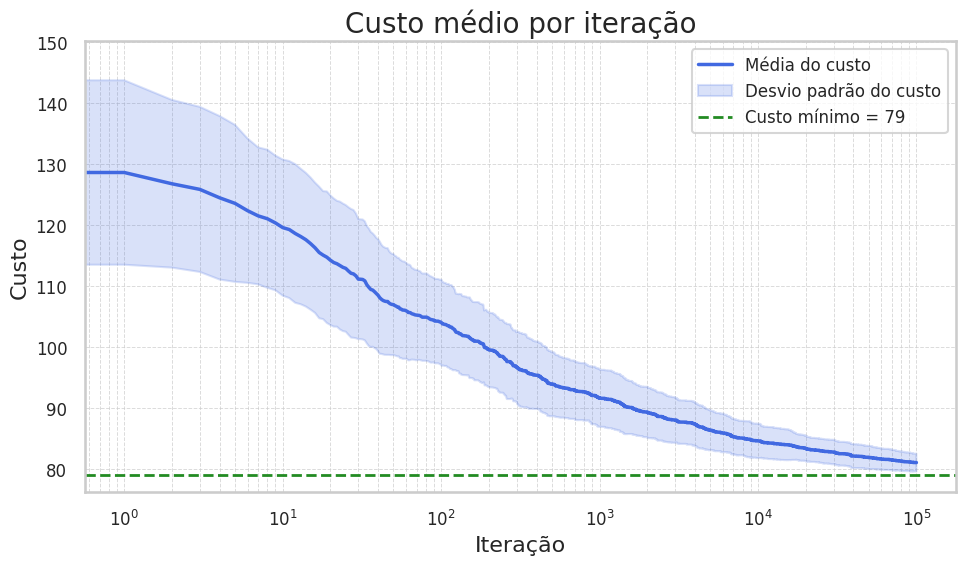

In [18]:
fig_costs, ax_costs = plt.subplots(figsize=(10, 6))

sns.lineplot(
    x=np.arange(len(means_by_iteration)),
    y=means_by_iteration,
    ax=ax_costs,
    label="Média do custo",
    color="royalblue",
    linewidth=2.5
)

ax_costs.fill_between(
    np.arange(len(means_by_iteration)),
    means_by_iteration - std_by_iteration,
    means_by_iteration + std_by_iteration,
    color="royalblue",
    alpha=0.2,
    label="Desvio padrão do custo"
)

ax_costs.axhline(
    y=min_cost,
    linestyle="--",
    color="forestgreen",
    linewidth=2,
    label=f"Custo mínimo = {min_cost}"
)

ax_costs.set_xscale("log")
ax_costs.set_title("Custo médio por iteração", fontsize=20)
ax_costs.set_xlabel("Iteração", fontsize=16)
ax_costs.set_ylabel("Custo", fontsize=16)
ax_costs.tick_params(axis='both', which='major', labelsize=12)
ax_costs.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
ax_costs.legend(fontsize=12, frameon=True)
plt.tight_layout()
plt.savefig("images/mean_cost_per_iteration.svg", dpi=300)
plt.show()

A Figura `fig_hist` mostra a distribuição dos valores de custo, com média em torno de 81. Este é um indicativo de um valor de mínimo local, já que grande parte das execuções obtem custo sobre esse valor e que dificilmente oferece melhorias em execuções posteriores.

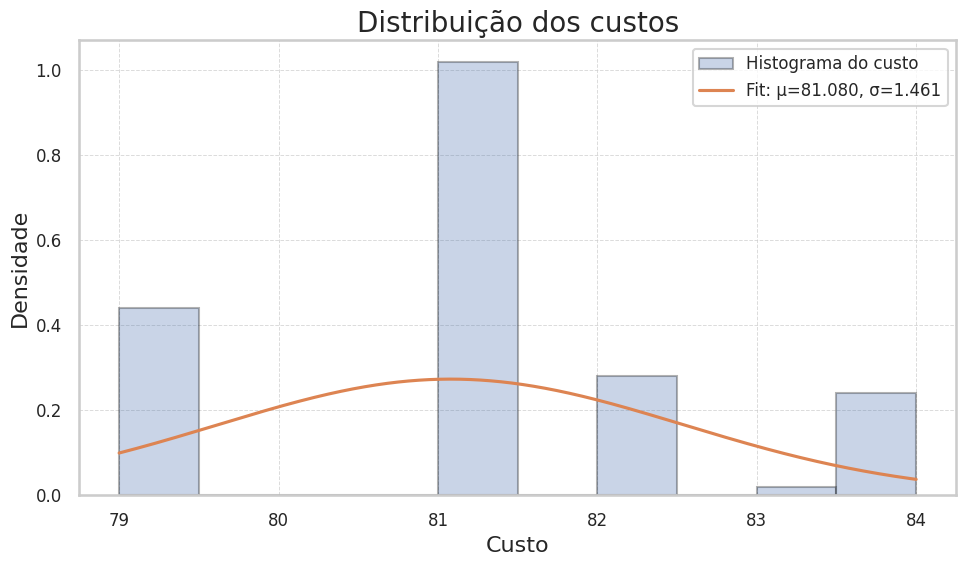

In [19]:
fig_hist, ax_hist = plt.subplots(figsize=(10, 6))

s = df["best_cost"]

mu, sigma = norm.fit(s)
x = np.linspace(min(s), max(s), 1000000)
pdf = norm.pdf(x, mu, sigma)
ax_hist.hist(s, bins=10, density=True, alpha=0.3, edgecolor="black", label=f"Histograma do custo")

ax_hist.plot(x, pdf, label=f"Fit: μ={mu:.3f}, σ={sigma:.3f}")
ax_hist.set_title(f"Distribuição dos custos", fontsize=20)
ax_hist.set_xlabel("Custo", fontsize=16)
ax_hist.set_ylabel("Densidade", fontsize=16)
ax_hist.tick_params(axis='both', which='major', labelsize=12)
ax_hist.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
ax_hist.legend(fontsize=12)
plt.tight_layout()
plt.savefig("images/cost_distribution.svg", dpi=300)
plt.show()

Por fim, serão extraídas duas novas colunas:

- `iteration_minimum`: a iteração onde foi encontrado pela primeira vez o valor de custo mínimo;
- `found_global`: indicação se a busca encontrou o mínimo global 79.

In [20]:
def find_minimum_iteration(x: List[float]) -> int:
    return np.where(x == x.min())[0][0]

df["iteration_minimum"] = df["history_cost"].apply(lambda x: find_minimum_iteration(x))
df["found_global"] = df["best_cost"].apply(lambda x: "Sim" if x == 79 else "Não")
df

,iteration,best_cost,best_solution,history_cost,history_solution,execution_time,memory_peak,memory_peak_mb,iteration_minimum,found_global
0,100000,79,[2 3 4 5 7 1 9 8 6],"[131, 131, 131, 131, 131, 131, 128, 122, 122, ...","[[2 3 4 5 7 1 9 8 6], [2 3 4 5 7 1 9 8 6], [2 ...",2.511995,1606745,1.606745,28816,Sim
1,100000,79,[7 4 8 1 9 2 6 5 3],"[147, 147, 147, 147, 141, 141, 122, 118, 118, ...","[[7 4 8 1 9 2 6 5 3], [7 4 8 1 9 2 6 5 3], [7 ...",2.525734,1606420,1.606420,30938,Sim
2,100000,81,[3 1 4 5 9 6 7 8 2],"[141, 141, 141, 141, 141, 141, 141, 141, 141, ...","[[3 1 4 5 9 6 7 8 2], [3 1 4 5 9 6 7 8 2], [3 ...",2.635656,1606514,1.606514,864,Não
3,100000,81,[7 1 9 6 8 2 5 4 3],"[131, 131, 131, 131, 131, 131, 131, 131, 131, ...","[[7 1 9 6 8 2 5 4 3], [7 1 9 6 8 2 5 4 3], [7 ...",2.492414,1609573,1.609573,36530,Não
4,100000,84,[6 3 1 8 9 7 4 2 5],"[103, 103, 103, 103, 103, 103, 103, 103, 103, ...","[[6 3 1 8 9 7 4 2 5], [6 3 1 8 9 7 4 2 5], [6 ...",2.524645,1606324,1.606324,3831,Não
...,...,...,...,...,...,...,...,...,...,...
95,100000,82,[9 1 7 6 2 8 5 3 4],"[141, 141, 141, 141, 141, 141, 141, 141, 141, ...","[[9 1 7 6 2 8 5 3 4], [9 1 7 6 2 8 5 3 4], [9 ...",2.358143,1607484,1.607484,968,Não
96,100000,81,[3 6 7 8 9 2 4 5 1],"[131, 130, 128, 122, 113, 113, 113, 113, 113, ...","[[3 6 7 8 9 2 4 5 1], [3 6 7 8 9 2 4 5 1], [3 ...",2.369169,1606443,1.606443,32461,Não
97,100000,82,[9 2 7 1 8 3 6 4 5],"[125, 113, 113, 113, 113, 113, 113, 113, 113, ...","[[9 2 7 1 8 3 6 4 5], [9 2 7 1 8 3 6 4 5], [9 ...",2.390874,1606560,1.606560,21538,Não
98,100000,81,[5 3 4 8 9 2 1 6 7],"[127, 127, 127, 127, 123, 117, 117, 117, 117, ...","[[5 3 4 8 9 2 1 6 7], [5 3 4 8 9 2 1 6 7], [5 ...",2.348094,1606516,1.606516,22887,Não


De posse dessas informações, podemos observar que as execuções que alcançaram o mínimo global precisam de um número de iterações da ordem de $10^3$, enquanto que as execuções que ficam presas em mínimos locais possuem um espalhamento um pouco maior. Portanto, não há garantia de encontrar mínimos globais com o aumento do número de iterações, mas podemos verificar que os mínimos são encontrados em grande parte a partir da época 1000, sejam eles locais ou globais.

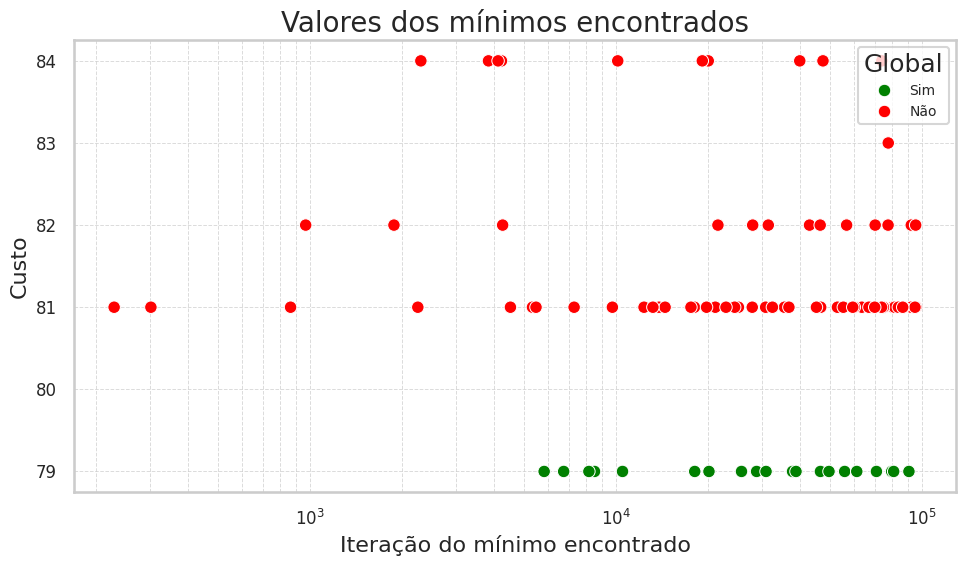

In [21]:
fig_scatter, ax_scatter = plt.subplots(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="iteration_minimum",
    y="best_cost",
    hue="found_global",
    palette={"Não": "red", "Sim": "green"},
    ax=ax_scatter
)
ax_scatter.set_xscale("log")
ax_scatter.set_title("Valores dos mínimos encontrados", fontsize=20)
ax_scatter.set_xlabel("Iteração do mínimo encontrado", fontsize=16)
ax_scatter.set_ylabel("Custo", fontsize=16)
ax_scatter.tick_params(axis='both', which='major', labelsize=12)
ax_scatter.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
ax_scatter.legend(title="Global", loc="upper right", fontsize=10)
plt.tight_layout()
plt.savefig("images/iteration_minimum_found_global.svg", dpi=300)
plt.show()

## 5.2. Distribuição do tempo de execução

Já em relação ao tempo de execução, a Figura `fig_time` ilustra um boxplot dos tempos de execução em segundos. Em média, as execuções amostradas tomam 2.3 segundos, podendo chegar até cerca de 2.6 segundos.

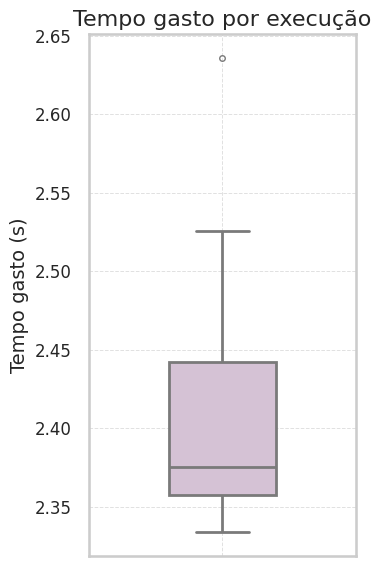

In [22]:
fig_time, ax_time = plt.subplots(figsize=(4, 6))

sns.boxplot(
    y=df["execution_time"],
    ax=ax_time,
    color="thistle",
    width=0.4,
    fliersize=4,
    linewidth=2
)

ax_time.set_title("Tempo gasto por execução", fontsize=16)
ax_time.set_ylabel("Tempo gasto (s)", fontsize=14)
ax_time.set_xlabel("")
ax_time.tick_params(axis='both', which='major', labelsize=12)
ax_time.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)
plt.tight_layout()
plt.savefig("images/execution_time_per_run.svg", dpi=300)
plt.show()

## 5.3. Pico de memória

Para o uso de memória, as execuções consomem cerca de 1.6 MB de memória, considerando que todo o histórico de custos e soluções é guardado em um objeto do tipo `Solution`. Há uma baixa variância nestes valores de consumo de memória, potencialmente em razão das otimizações de alocação de memória da biblioteca Numpy, somado ao fato de que o estudo percorre todas as iterações possíveis.

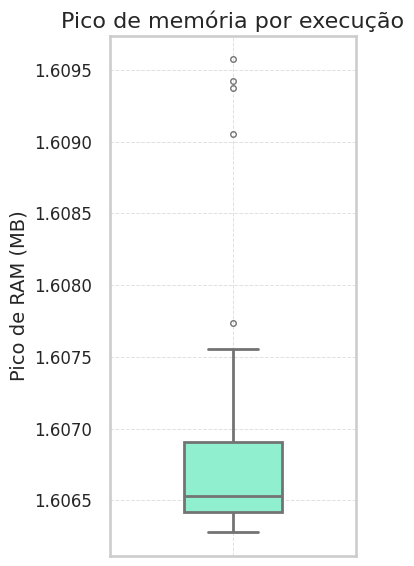

In [23]:
fig_peak, ax_peak = plt.subplots(figsize=(4, 6))

sns.boxplot(
    y=df["memory_peak_mb"],
    ax=ax_peak,
    color="aquamarine",
    width=0.4,
    fliersize=4,
    linewidth=2
)

ax_peak.set_title("Pico de memória por execução", fontsize=16)
ax_peak.set_ylabel("Pico de RAM (MB)", fontsize=14)
ax_peak.set_xlabel("")
ax_peak.tick_params(axis='both', which='major', labelsize=12)
ax_peak.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)
plt.tight_layout()
plt.savefig("images/memory_peak_per_run.svg", dpi=300)
plt.show()